# Interpolating Mass Loss from Stellar Evolution Data

You can always modify the mass of particles between calls to `sim.integrate`.  However, if you want to apply stellar evolution data at every timestep *within* calls to `sim.integrate`, you can use the `stellar_evo` operator. For example, if you have several time-mass values describing mass loss stored in an array, this effect will use a cubic spline to _interpolate_ the particle's mass between integrations at any time, `sim.t`.

We begin by setting up a system with 3 planets.

In [1]:
import rebound
import reboundx
import numpy as np

M0 = 1. # initial mass of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2 # use units of AU, yrs and solar masses

    sim.add(m=M0, hash="star")
    sim.add(a=1.)
    sim.add(a=2.)
    sim.add(a=3.)
    sim.move_to_com()
    return sim

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


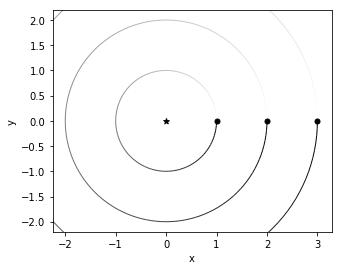

In [2]:
%matplotlib inline
sim = makesim()
ps = sim.particles
fig = rebound.OrbitPlot(sim)

We now invoke stellar evolution through REBOUNDx:

In [3]:
rebx = reboundx.Extras(sim)
sml = rebx.load_operator("mass_evolution")
rebx.add_operator(sml)

Here we pass four required parameters to inform the simulation how the mass will change by interpolating our dataset (see detailed explanations in the [effect description](https://reboundx.readthedocs.io/en/latest/effects.html#modify-mass)). Unlike a typical Python _list_, datasets must be _wrapped_ as `ctypes` objects to be accepted by the effect. _Note_: the size of all three arrays must be the same (i.e., the number `mass_n`).

Here we have seven (7) values that correspond to a star _losing_ mass with an e-folding timescale of $10^4$ yrs.

In [4]:
from ctypes import *

Nvalues = 7
DoubleArray = c_double * Nvalues # fixed, mass_n-sized, double array
times = DoubleArray(0., 2000., 4000., 6000., 8000., 10000., 12000.)
values = DoubleArray(1., 0.81873075307, 0.67032004603, 0.54881163609, 0.44932896411, 0.36787944117, 0.30119421191)

sml.params['me_hash'] = ps[0].hash
sml.params['me_times'] = times
sml.params['me_values'] = values
sml.params['me_Nvalues'] = Nvalues

Now we integrate for one e-folding timescale, and plot the resulting system:

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:675: RuntimeWarning: REBOUNDx: Operators that affect particle trajectories with adaptive timesteps can give spurious results. Use sim.ri_ias15.epsilon=0 for fixed timestep with IAS, or use a different integrator.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


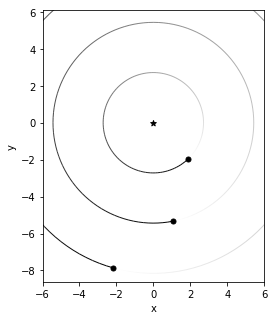

In [5]:
Nout = 1000
mass = np.zeros(Nout)
ts = np.linspace(0., 1.e4, Nout)

for i, time in enumerate(ts):
    sim.integrate(time)
    mass[i] = sim.particles[0].m
    
fig = rebound.OrbitPlot(sim)

We see that after the mass of the star has decayed by a factor of `e`, the scale of the system has expanded by the corresponding factor, as one would expect.  If we plot the mass of the star vs time, compared to an exponential decay, the two overlap. We also plot the dataset, i.e., time-mass values, for comparison.

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


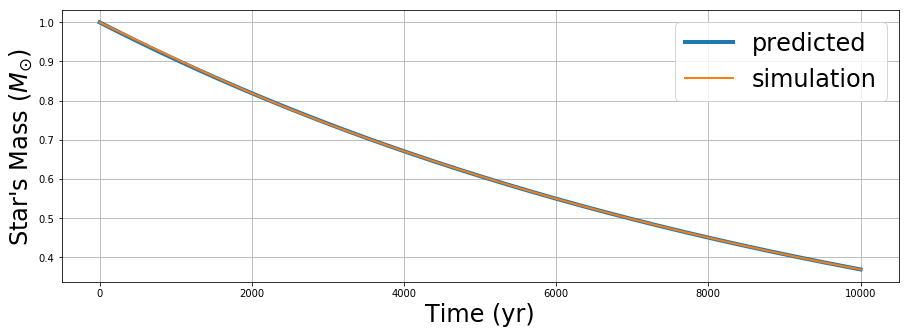

In [6]:
import matplotlib.pyplot as plt

pred = M0*np.e**(ts/-1.e4)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.plot(ts,pred, linewidth="4", label='predicted')
ax.plot(ts,mass, linewidth="2", label='simulation')
#ax.plot(mass_age[:6], mass_val[:6], "o", color="black", markersize="8", label='dataset')
ax.set_xlabel("Time (yr)", fontsize=24)
ax.set_ylabel("Star's Mass ($M_{\odot}$)", fontsize=24)
ax.legend(fontsize=24)
ax.grid()